# PyTorch: Autoencoder Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb


In [106]:
# 1.a)
import os
import pickle
import datetime
from collections import defaultdict

In [107]:
# 1.b)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import dill
import json

In [134]:
# 1.c)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose

import shelve

#from torchviz import make_dot

In [109]:
# # 1.d)
# import google.colab
# from google.colab import files

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Ejercicio 2)** 

Bajando y Jugando con el dataset **Fashion-MNIST**.

**a)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**b)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**c)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**d)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [111]:
# 2.a)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
trainset_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [112]:
# 2.b)
trainset = trainset_orig
testset = testset_orig

In [139]:
def model_test(model,image_name): #funcion para plotear los resultados
  figure = plt.figure()
  rows,cols = 3,2
  i = 0 # subplot index
  for row in range(1,rows+1):
      j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
      # Ploteamos la imagen original
      i += 1
      image,flatten_imagen = trainset[j]
      figure.add_subplot(rows,cols,i)
      if row==1:
        plt.title("original")
      plt.axis("off")
      plt.imshow(image.squeeze(),cmap="Greys_r")
      # Ploteamos la imagen predicha
      i += 1
      figure.add_subplot(rows,cols,i)
      if row==1:
        plt.title("predicha")
      plt.axis("off")
      #image_pred = model.imagen(image)
      #plt.imshow(image_pred,cmap="Greys_r")
      with torch.no_grad(): # 
          image_gpu = image
      pred_gpu = model(image_gpu)
      pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
      plt.imshow(pred_cpu,cmap="Greys_r")    
      
  plt.savefig(image_name)
  plt.show()

In [113]:
len(trainset),len(testset)#,len(validset)

(60000, 10000)

In [114]:
len(trainset),len(testset)

(60000, 10000)

In [115]:
# Graficamos la imagen
# plt.imshow(image.squeeze(),cmap="Greys_r")

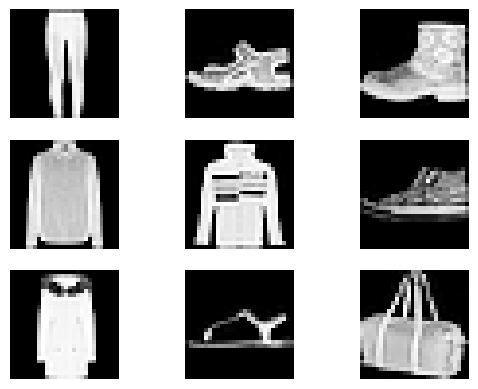

In [116]:
# 2.d)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = trainset[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**a)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**b)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.

In [117]:
# 3.a)
# Creamos una subclase de Dataset que nos sirva para muestrear imagenes en el entrenamiento del autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return image,label

In [118]:
# 3.b)
# Convertimos FashionMNIST Dataset a CustomDataset para 
trainset = CustomDataset(trainset)
testset = CustomDataset(testset)


## Ejercicio 4) Red Neuronal Autoencoder

**a)** Cree una red neuronal de 2 capas, una oculta de $n$ neuronas y las de entrada y salida de $28\times 28=784$ neuronas.
En la capa intermedia y la de salida utilice neuronas tipo ReLU.
Las capas sucesivas tienen que estar totalmente conectadas entre si.
Agregue un dropout de 0.2.

**b)** Grafique, comparativamente, las imagenes a predecir vs las imagenes predichas por el modelo sin entrenar.

In [119]:
# 4.a)
class Autoencoder(nn.Module):
    def __init__(self,n):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            
            nn.Linear(28*28,n),
            nn.Dropout(0.1),
            nn.ReLU(),
            
            nn.Linear(n,28*28),
            nn.Dropout(0.1),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)

In [120]:
# Creamos el modelo
n = 64
#model = NeuralNetwork(n)
model = Autoencoder(n)

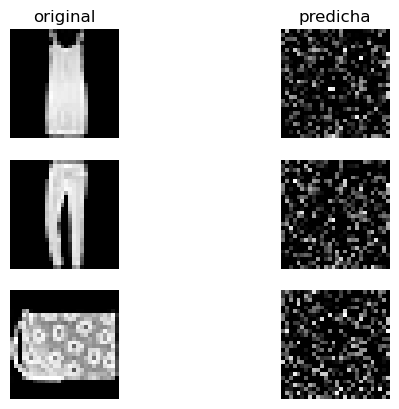

In [121]:
# Miramos que imagenes predice el modelo sin entrenar
# 4.b)
figure = plt.figure()
rows,cols = 3,2
i = 0 # subplot index
for row in range(1,rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = trainset[j]
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha")
    plt.axis("off")
    #image_pred = model.imagen(image)
    image_gpu = image.to(device)
    pred_gpu = model(image_gpu)
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu,cmap="Greys_r")
plt.show()

## Ejercicio 5) Entrenando el modelo

**a)** Implemente, en una función, un loop de entrenamiento que recorra los batchs.

**b)** Implemente, en una función, un loop de testeo que recorra los batchs.

**c)** Defina el rate de entrenamiento y el tamaño de los batchs en $10^{-3}$ y $1000$ respectivamente.

**d)** Inicialize los `DataLoaders` nuevamente.

**e)** Cree una función de pérdida usando la MSE-Loss y un optimizador.
Pruebe con el SGD y ADAM.

**f)** Implemente un loop de entrenamiento y testeo que recorra un numero arbitrario de épocas.
Este loop debe guardar en respectivas listas los valores de los promedios de la MSE-Loss sobre el conjunto de entrenamiento y el de testeo.

**g)** Use las listas del inciso anterior para graficar en función de las épocas la MSE-Loss de entrenamiento y la MSE-Loss de testeo.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**h)** Grafique, comparativamente, las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

In [122]:
# 5.a) y 5.b)
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer):
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_train_loss = 0
    # Movemos el modelo a la GPU
    model = model.to(device)
    model.train()
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Movemos el lote a la GPU
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_batch = loss.item()
        sum_train_loss += loss_batch
        if batch % 5 == 0:
            current = batch*len(X)
            print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")
    avg_train_loss = sum_train_loss/num_batches
    return avg_train_loss

# De manera similar, definimos la función de testeo
def test_loop(dataloader,model,loss_fn):
    # Definimos ciertas constantes  
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_test_loss,sum_correct = 0,0
    # Movemos el modelo a la GPU
    model = model.to(device)
    model.eval()
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Movemos el lote a la GPU
            X,y = X.to(device),y.to(device)          
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            loss_batch = loss_fn(pred,y).item()
            sum_test_loss += loss_batch
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            #sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_test_loss = sum_test_loss/num_batches
    #frac_correct = sum_correct/size
    #print(f"Test Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")
    print(f"Test Error: Avg loss: {avg_test_loss:>8f} \n")
    return avg_test_loss

In [123]:
# 5.c)
# Definimos
learning_rate = 1e-3
batch_size = 1000

In [124]:
# 5.d)
# Creamos los DataLoaders
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = True)

In [125]:
# 5.e)
# Creamos una instancia de una función de pérdida, una entropy loss en este caso
#loss_fn = nn.CrossEntropyLoss() # Para clasificación
# loss_fn = nn.MSELoss() # Para autoencoder
# # y un optimizador, un Stochastic Gradient Descent, en este caso.
# # optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
# # o, alternativamente, un optimizador tipo ADAM.
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [126]:
# # 5.f)
# # Finalmente, entrenamos iterando sobre épocas.
# # Además, testeamos el modelo en cada una de ellas.
# num_epochs = 30
# list_avg_train_loss = []
# list_avg_test_train_loss = []
# list_avg_test_loss = []
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch+1}\n-------------------------------")
#     avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
#     avg_test_train_loss = test_loop(trainloader,model,loss_fn)
#     avg_test_loss = test_loop(testloader,model,loss_fn)
#     list_avg_train_loss.append(avg_train_loss)
#     list_avg_test_train_loss.append(avg_test_train_loss)
#     list_avg_test_loss.append(avg_test_loss)
# print("Done!")

In [164]:
import shelve

# # descomentar para usar SGD
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/modelos entrenados/"
list_of_models = ['SGD_lr1e-1_n_']#,'SGD_lr1e-2_n_','SGD_lr1e-3_n_'] 


# path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"
# list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 

list_learning_rate = [1e-1]#,1e-2,1e-3]

neuron_numbers = [64,128,256,512]

for lr,model_i in enumerate(list_of_models):
    
    for n in neuron_numbers:
        
        model = Autoencoder(n)
        
        loss_fn = nn.MSELoss()
        
        optimizer = torch.optim.SGD(model.parameters(),lr=list_learning_rate[lr],momentum=0.9)
        # optimizer = torch.optim.Adam(model.parameters(),lr=list_learning_rate[lr],eps=1e-08,weight_decay=0,amsgrad=False)
        
        num_epochs = 100
        
        list_avg_train_loss = []
        list_avg_test_train_loss = []
        list_avg_test_loss = []
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}\n-------------------------------")
            avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
            avg_test_train_loss = test_loop(trainloader,model,loss_fn)
            avg_test_loss = test_loop(testloader,model,loss_fn)
            list_avg_train_loss.append(avg_train_loss)
            list_avg_test_train_loss.append(avg_test_train_loss)
            list_avg_test_loss.append(avg_test_loss)
        print("Done!")

        
        models = shelve.open(path + model_i+str(n)+'.db')
        models['auto']=model
        models['train_loss']= list_avg_train_loss
        models['test_loss']=list_avg_test_loss
        models['test_train_loss'] = list_avg_test_train_loss

        models.close()
        print(model_i +str(n)+ "Done!")

Epoch 1
-------------------------------
batch=0 loss=0.184314  muestras-procesadas:[    0/60000]
batch=5 loss=0.177978  muestras-procesadas:[ 5000/60000]
batch=10 loss=0.170905  muestras-procesadas:[10000/60000]
batch=15 loss=0.160230  muestras-procesadas:[15000/60000]
batch=20 loss=0.154108  muestras-procesadas:[20000/60000]
batch=25 loss=0.148623  muestras-procesadas:[25000/60000]
batch=30 loss=0.144527  muestras-procesadas:[30000/60000]
batch=35 loss=0.140358  muestras-procesadas:[35000/60000]
batch=40 loss=0.133555  muestras-procesadas:[40000/60000]
batch=45 loss=0.129276  muestras-procesadas:[45000/60000]
batch=50 loss=0.129665  muestras-procesadas:[50000/60000]
batch=55 loss=0.127462  muestras-procesadas:[55000/60000]
Test Error: Avg loss: 0.111641 

Test Error: Avg loss: 0.111504 

Epoch 2
-------------------------------
batch=0 loss=0.125730  muestras-procesadas:[    0/60000]
batch=5 loss=0.122994  muestras-procesadas:[ 5000/60000]
batch=10 loss=0.124646  muestras-procesadas:[1

In [127]:
# import shelve

# # # descomentar para usar SGD
# # path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/modelos entrenados/"
# # list_of_models = ['SGD_lr1e-1_n_','SGD_lr1e-2_n_','SGD_lr1e-3_n_'] 


# path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"
# list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 

# list_learning_rate = [1e-1,1e-2,1e-3]

# neuron_numbers = [64,128,256,512]

# for lr,model_i in enumerate(list_of_models):
    
#     for n in neuron_numbers:
        
#         model = Autoencoder(n)
        
#         loss_fn = nn.MSELoss()
        
#         # optimizer = torch.optim.SGD(model.parameters(),lr=list_learning_rate[lr],momentum=0.9)
#         optimizer = torch.optim.Adam(model.parameters(),lr=list_learning_rate[lr],eps=1e-08,weight_decay=0,amsgrad=False)
        
#         num_epochs = 100
        
#         list_avg_train_loss = []
#         list_avg_test_train_loss = []
#         list_avg_test_loss = []
#         for epoch in range(num_epochs):
#             print(f"Epoch {epoch+1}\n-------------------------------")
#             avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
#             avg_test_train_loss = test_loop(trainloader,model,loss_fn)
#             avg_test_loss = test_loop(testloader,model,loss_fn)
#             list_avg_train_loss.append(avg_train_loss)
#             list_avg_test_train_loss.append(avg_test_train_loss)
#             list_avg_test_loss.append(avg_test_loss)
#         print("Done!")

        
#         models = shelve.open(path + model_i+str(n)+'.db')
#         models['auto']=model
#         models['train_loss']= list_avg_train_loss
#         models['test_loss']=list_avg_test_loss
#         models['test_train_loss'] = list_avg_test_train_loss

#         models.close()
#         print(model_i +str(n)+ "Done!")

Epoch 1
-------------------------------
batch=0 loss=0.181773  muestras-procesadas:[    0/60000]
batch=5 loss=0.245480  muestras-procesadas:[ 5000/60000]
batch=10 loss=0.202543  muestras-procesadas:[10000/60000]
batch=15 loss=0.208709  muestras-procesadas:[15000/60000]
batch=20 loss=0.201915  muestras-procesadas:[20000/60000]
batch=25 loss=0.202914  muestras-procesadas:[25000/60000]
batch=30 loss=0.197032  muestras-procesadas:[30000/60000]
batch=35 loss=0.208564  muestras-procesadas:[35000/60000]
batch=40 loss=0.205003  muestras-procesadas:[40000/60000]
batch=45 loss=0.213868  muestras-procesadas:[45000/60000]
batch=50 loss=0.203852  muestras-procesadas:[50000/60000]
batch=55 loss=0.207269  muestras-procesadas:[55000/60000]
Test Error: Avg loss: 0.206445 

Test Error: Avg loss: 0.206499 

Epoch 2
-------------------------------
batch=0 loss=0.205001  muestras-procesadas:[    0/60000]
batch=5 loss=0.210647  muestras-procesadas:[ 5000/60000]
batch=10 loss=0.209811  muestras-procesadas:[1

In [133]:
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"
neuron_numbers = [64,128,256,512]
list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 

dyct_adam = {}

for model in list_of_models:
    for n in neuron_numbers:
        model_name = model+ str(n) +".db"
        modelos_=shelve.open(path + model_name)

        # list_avg_train_loss = modelos_['test_train_loss'][-10:].mean()  # notar que tome el test_train_loss
        best_10 = np.mean(modelos_['test_loss'][-10:])
        dyct_adam[model_name] = best_10

In [137]:
sorted(dyct_adam.items(), key=lambda item: item[1])[:4] # todos pertenecen a el lr de 1e-1

[('adam_lr1e-3_n_512.db', 0.007386826062574983),
 ('adam_lr1e-3_n_256.db', 0.009186674281954767),
 ('adam_lr1e-3_n_128.db', 0.010878186654299498),
 ('adam_lr1e-3_n_64.db', 0.015299956137314438)]

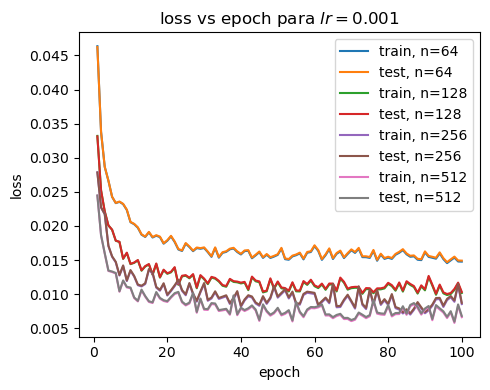

In [163]:
# graficador de loss
# %matplotlib qt
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"
neuron_numbers = [64,128,256,512]
# list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 
list_of_models = ['adam_lr1e-3_n_']
plt.figure(figsize=(5,4))
for i, model in enumerate(list_of_models):
    for n in neuron_numbers:

        modelos_=shelve.open(path + model + str(n) +".db")

        list_avg_train_loss = modelos_['test_train_loss']
        list_avg_test_loss = modelos_['test_loss']
        plt.xlabel('epoch')
        plt.ylabel('loss')
        # plt.xlim(80,106)
        # plt.ylim(0.005,0.018)
        plt.plot(range(1,len(list_avg_train_loss)+1),list_avg_train_loss,label="train"+", n="+str(n))
        plt.plot(range(1,len(list_avg_test_loss)+1),list_avg_test_loss,label= "test"+", n="+str(n))
        plt.title('loss vs epoch para $lr = 0.001$')
        plt.tight_layout()
        plt.legend()

plt.savefig('adam_best_loss.png')


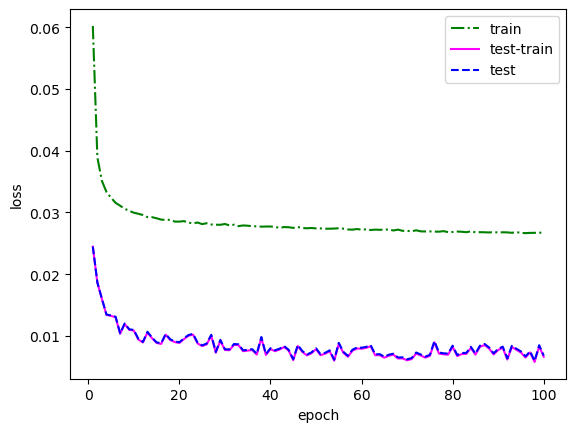

In [136]:
%matplotlib inline
# 5.g)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.xlim(-0.1,5.1)
#plt.ylim(-0.1,1.1)
plt.plot(list(range(1,len(list_avg_train_loss)+1)),list_avg_train_loss,label="train",linestyle='-.',c='green')
plt.plot(list(range(1,len(list_avg_test_loss)+1)),list_avg_test_train_loss,label="test-train",linestyle='-',c='magenta')
plt.plot(list(range(1,len(list_avg_test_loss)+1)),list_avg_test_loss,label="test",linestyle='--',c='blue')
plt.title('')
plt.legend()

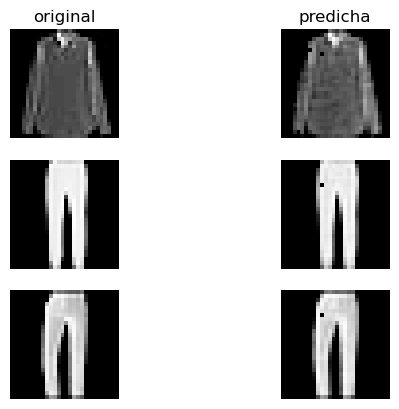

In [129]:
# Miramos que imagenes predice el modelo entrenado
# 5.h)
figure = plt.figure()
rows,cols = 3,2
i = 0 # subplot index
for row in range(1,rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = trainset[j]
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha")
    plt.axis("off")
    #image_pred = model.imagen(image)
    #plt.imshow(image_pred,cmap="Greys_r")
    with torch.no_grad(): # 
        image_gpu = image.to(device)
    pred_gpu = model(image_gpu)
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu,cmap="Greys_r")    
plt.show()